In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
from nltk.metrics import masi_distance
from collections import Counter
from nltk.metrics import agreement
from nltk.metrics.agreement import AnnotationTask

In [3]:
import re

def depersonalize(text):
    text = str(text)
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text= re.sub(url_regex, "url", text)
    text = re.sub("id[\d]*",'',text)
    text = re.sub("> ?",'',text)
    text = re.sub("@[\w]*",'',text)
#     text = re.sub("\+[\d]*", "", text)
    text = re.sub("[\d]+", "NUMBER", text)
    text = re.sub(">>", "", text)
#     text = re.sub("[\d]{3,100}", "", text)
    text = re.sub("[\t|\n|\r]", "", text)
    text = re.sub("[(OP)|url|nickname|phone_number]", "", text)
    return text

In [4]:
df_sensitive = pd.read_csv("sensitive_topics_vers3.csv")

In [5]:
Counter(df_sensitive['source'])

Counter({'toloka': 8766,
         'trtest': 378,
         'self': 1978,
         'kw': 21656,
         'toloka_real_manual_relabel': 526,
         'no_kw_manual_relabel': 600})

In [6]:
df_sensitive_toloka = df_sensitive[df_sensitive['source'] == 'toloka']
toloka_trtes_set = set(df_sensitive[df_sensitive['source']=='trtest']['text'])

In [7]:
len(toloka_trtes_set)

378

In [8]:
df_sensitive_toloka_texts_set = set(df_sensitive_toloka['text'])
len(df_sensitive_toloka_texts_set)

8766

In [9]:
old2new_topic = {'crime_real':'offline_crime','crime_web':'online_crime','halth_shaming':'health_shaming',
                'social':'social_injustice','sex_minorities':'sexual_minorities'}

topics = list(df_sensitive.columns[1:-1])

In [10]:
# def update_batch_dict(df_hc, thrsh, collected_texts_dict, file):
#     confidnece_columns = []
#     output_columns = []
#     for c in df_hc.columns:
#         if 'CONFIDENCE' in c:
#             df_hc[c] = df_hc[c].apply(lambda x: float(x[:-1])/100)
#             confidnece_columns.append(c)
#         if 'OUTPUT' in c:
#             output_columns.append(c)
    
#     meet_req_list = []
    
#     for i, el in df_hc.iterrows():
# #         confidence_above_threshold = all([el[c] > thrsh for c in confidnece_columns if c not in ('CONFIDENCE:none',
# #                                                                                              'CONFIDENCE:obscene',
# #                                                                                              'CONFIDENCE:toxic')])
        
#         confidence_above_threshold = all([el[c] > thrsh for c in confidnece_columns])
        
#         meet_req_list.append(confidence_above_threshold)
        
#         collected_topics_conf = [0] * 18
#         for confidence_colname, output_colname in zip(confidnece_columns, output_columns):
#             short_topic = confidence_colname[11:]
#             assert short_topic in output_colname
#             output_value = el[output_colname]
#             confidence_value = el[confidence_colname] if output_value == True else 1 - el[confidence_colname]
#             if short_topic in ('none','obscene','toxic'):
#                 continue
#             short_topic = old2new_topic.get(short_topic, short_topic)
            
#             topic_index = topics.index(short_topic)
#             collected_topics_conf[topic_index] = confidence_value

#         if el['INPUT:text'] in collected_texts_dict:
# #             collected_texts_dict[el['INPUT:text']]['is_high_conf'] = confidence_above_threshold 
            
#             if collected_texts_dict[el['INPUT:text']]['is_high_conf'] != False:#false нельзя исправлять. если один раз не соотве то все
#                 collected_texts_dict[el['INPUT:text']]['is_high_conf'] = confidence_above_threshold 
#             new_topics_list = []
#             for existing_values, values_to_add in zip(collected_texts_dict[el['INPUT:text']]['topics_conf'], collected_topics_conf):
#                 if existing_values > 0:
#                     assert values_to_add == 0, "{} {}".format(i, el['text'])

#                 new_topics_list.append(existing_values+values_to_add)  
#             new_topics_list = [round(v,3) for v in new_topics_list]
#             assert len(new_topics_list) == 18
#             collected_texts_dict[el['INPUT:text']]['topics_conf'] = new_topics_list
#             collected_texts_dict[el['INPUT:text']]['file'].append(file)
            
#         else:
#             collected_texts_dict[el['INPUT:text']] = {}
#             collected_texts_dict[el['INPUT:text']]['topics_conf'] = [round(v,3) for v in collected_topics_conf]
#             collected_texts_dict[el['INPUT:text']]['is_high_conf'] = confidence_above_threshold
#             collected_texts_dict[el['INPUT:text']]['file'] = [file]
#     df_hc['meet_req'] = meet_req_list
# #     return set(df_hc[df_hc['meet_req'] == True]['INPUT:text'])   
#     return set([k for k,v in collected_texts_dict.items() if v['is_high_conf'] == True])

In [11]:
def calc_agreement_nltk(df_group):
    worker2id = {}
    for pair in df_group['ASSIGNMENT:worker_id'].tolist():
        if pair not in worker2id:
            worker2id[pair] = len(worker2id)
    df_group['worker_idx'] = df_group['ASSIGNMENT:worker_id'].map(worker2id)
    
    text2ids = {}
    for t in set(df_group['INPUT:text'].tolist()):
        if t not in text2ids:
            text2ids[t] = len(text2ids)
    df_group['text_idx'] = df_group['INPUT:text'].map(text2ids)
    ids2text = {idx:text for text,idx in text2ids.items()}
    
    reply_columns = [c for c in df_group.columns if 'OUTPUT' in c]
    
    collected_data = []
    item_idx_dict = {}
    
    for i,el in df_group.iterrows():
        coder_idx = el['worker_idx']
        
        item_idx = el['text_idx']
        
        if item_idx in item_idx_dict:
            item_idx_dict[item_idx] += 1
        else:
            item_idx_dict[item_idx] = 1
            
        labels_list = []
        for repl in reply_columns:
            if el[repl] == True:
                labels_list.append(repl[7:])

        if len(labels_list) == 0: labels_list = ['none']
        collected_triplet = (coder_idx,item_idx,frozenset(labels_list))
        collected_data.append(collected_triplet)
        
    task = AnnotationTask(distance = masi_distance)
    
    task.load_array(collected_data)
    
    return task.alpha()

def split_df_upon_confidence(df_hc, thrsh):
    confidnece_columns = []
    for c in df_hc.columns:
        if 'CONFIDENCE' in c:
            df_hc[c] = df_hc[c].apply(lambda x: float(x[:-1])/100)
            confidnece_columns.append(c)
    
    meet_req_list = []
    for i, el in df_hc.iterrows():
        #ЕСЛИ ТАК ДЕЛАТЬ ТО СОГЛАСОВАННОСТЬ ПАДАЕТ
#         all_above = all([el[c] > thrsh for c in confidnece_columns if c not in ('CONFIDENCE:none',
#                                                                                              'CONFIDENCE:obscene',
#                                                                                              'CONFIDENCE:toxic')])
        all_above = all([el[c] > thrsh for c in confidnece_columns])
        meet_req_list.append(all_above)
    df_hc['meet_req'] = meet_req_list 
    
#     df_hc['meet_req'] = df_hc.apply(lambda x: all([x[c] > thrsh for c in confidnece_columns]), axis = 1)
    
    return df_hc[df_hc['meet_req'] == True], df_hc[df_hc['meet_req'] == False]

def process_dict(dct_sep):
    columns = ['text'] + topics + ['source']
    data = []
    for text, values in dct_sep.items():
        current_data = [text]
        current_data += values['topics_conf']
        current_data.append(values['file']) 
        data.append(current_data)
    return pd.DataFrame(data = data, columns = columns)

def dict2pd(dct):
    dct_meetreq = {k:v for k,v in dct.items() if v['is_high_conf'] == True}
    
    dct_NO_meetreq = {k:v for k,v in dct.items() if v['is_high_conf'] == False}
    
    return process_dict(dct_meetreq), process_dict(dct_NO_meetreq)
    
def get_aggr_batch_with_filtering(batch_name, drop_unconfident_thrsh = None, 
                                  drop_traintest_examples = False, print_output = True, drop_trtest = True):
    if batch_name == 'first': 
        raw_files = ['g1r.tsv','g2r.tsv','g3r.tsv']
    elif batch_name == 'fourth':
        raw_files = ['g1_4r.tsv','g2_4r.tsv','g3_4r.tsv']
    elif batch_name == 'old':
        raw_files = ['maybe_old/g1r.tsv','maybe_old/g2r.tsv']
    
    engaged_texts_high_conf= set()
   
    collected_agreements = []
    collected_datasets_high_conf = []
    collected_datasets_low_conf = []
    
    for i, file in enumerate(raw_files):
        if print_output == True: print("="*100)
        batch_path = "./directly_from_toloka/"+file
        df_curr_common= pd.read_csv(batch_path, sep = '\t')
        
        if drop_trtest == True:
            if print_output == True: print("before dropping trtest ...", len(df_curr_common))
            df_curr_common = df_curr_common[~df_curr_common['INPUT:text'].isin(toloka_trtes_set)]#!!
            if print_output == True: print("after dropping trtest ...", len(df_curr_common))
            
        if drop_unconfident_thrsh:
            file_agg = re.sub('r','',file)
            batch_path_agg = "./directly_from_toloka/"+file_agg
            df_curr_agg = pd.read_csv(batch_path_agg, sep = '\t')
        
            df_aggr_high_conf,df_aggr_low_conf = split_df_upon_confidence(df_curr_agg, drop_unconfident_thrsh)
            collected_datasets_high_conf.append(df_aggr_high_conf)
            collected_datasets_low_conf.append(df_aggr_low_conf)
            
            if print_output == True: print("before dropping low conf ... ", len(df_curr_common))
            df_curr_common = df_curr_common[df_curr_common['INPUT:text'].isin(df_aggr_high_conf['INPUT:text'])]
            if print_output == True: print("after dropping low conf ...", len(df_curr_common))
                
        engaged_texts_high_conf = engaged_texts_high_conf.union(set(df_curr_common['INPUT:text']))
        

        columns_to_merge = [c for c in df_curr_common.columns if c == 'INPUT:text' or 'OUTPUT' in c  or c =='ASSIGNMENT:worker_id']
        df_curr_common = df_curr_common[columns_to_merge]
        
        alpha_curr = calc_agreement_nltk(df_curr_common)
            
        collected_agreements.append(alpha_curr)
        
    df_hc = pd.concat(collected_datasets_high_conf)
    
    df_lc = pd.concat(collected_datasets_low_conf)
    
    df_hc_actually_low = df_hc[df_hc['INPUT:text'].isin(df_lc['INPUT:text'])]
    df_hc_actually_high = df_hc[~df_hc['INPUT:text'].isin(df_lc['INPUT:text'])]
    
    df_lc_really_low = pd.concat([df_hc_actually_low,df_lc])

    set_df_hc = set(df_hc_actually_high['INPUT:text'])
    set_df_lc = set(df_lc_really_low['INPUT:text'])

    if print_output == True:
        print('----')
        print("set_df_hc", len(set_df_hc))
        print("set_df_lc", len(set_df_lc))
        print("intersect 2 different datsastes", len(set_df_hc & set_df_lc))
    
    return collected_agreements, engaged_texts_high_conf, df_hc_actually_high, df_lc_really_low
#если отдавать тексты engaged_texts_high_conf в рамках батча то кол-во сораняемых текстов выше
# если отдавать датафрейм сформированный из всех только выосоуверенных семплов то ниже
    

aggr, engtxt, dfhc, dflc = get_aggr_batch_with_filtering('first',drop_unconfident_thrsh = 0.8, print_output = True)

before dropping trtest ... 12705
after dropping trtest ... 10006
before dropping low conf ...  10006
after dropping low conf ... 7668
before dropping trtest ... 15009
after dropping trtest ... 12250
before dropping low conf ...  12250
after dropping low conf ... 8540
before dropping trtest ... 16934
after dropping trtest ... 13810
before dropping low conf ...  13810
after dropping low conf ... 8641
----
set_df_hc 1837
set_df_lc 557
intersect 2 different datsastes 0


In [12]:
aggr, len(engtxt), len(dfhc), len(dflc)

([0.39641539683044846, 0.6211801748074177, 0.39857040655455145],
 2289,
 5226,
 1671)

In [ ]:
# first - при новом подсчете однако проще относимся к обнволяемости допустимости требований
# ====================================================================================================
# before dropping trtest ... 12705
# after dropping trtest ... 10006
# before dropping low conf ...  10006
# after dropping low conf ... 7673
# ====================================================================================================
# before dropping trtest ... 15009
# after dropping trtest ... 12250
# before dropping low conf ...  12250
# after dropping low conf ... 8977
# ====================================================================================================
# before dropping trtest ... 16934
# after dropping trtest ... 13810
# before dropping low conf ...  13810
# after dropping low conf ... 9648

In [154]:
# first - при простом подсчете - метрики норм
# ====================================================================================================
# before dropping trtest ... 12705
# after dropping trtest ... 10006
# before dropping low conf ...  10006
# after dropping low conf ... 7668
# ====================================================================================================
# before dropping trtest ... 15009
# after dropping trtest ... 12250
# before dropping low conf ...  12250
# after dropping low conf ... 8540
# ====================================================================================================
# before dropping trtest ... 16934
# after dropping trtest ... 13810
# before dropping low conf ...  13810
# after dropping low conf ... 8641

In [17]:
def get_filter_stats_from_all_batches(drop_unconfident_thrsh, batches = ['first','fourth','old'],drop_trtest=False):
    
    collected_agreements = []
    
    texts_set = set ()
    texts_set_from_df = set()
    for batch in batches:#
        print(batch)
        aggr_lst_curr, eng_txt_hc, df_hc, df_lc = get_aggr_batch_with_filtering(batch, 
                                                                     drop_unconfident_thrsh = drop_unconfident_thrsh,
                                                                    drop_trtest = drop_trtest)
        collected_agreements.extend(aggr_lst_curr)
        
        texts_set = texts_set.union(eng_txt_hc)
        texts_set_from_df = texts_set_from_df.union(set(df_hc['INPUT:text']))
            
    
    return np.mean(aggr_lst_curr), texts_set, texts_set_from_df
    
agrmnt, alltxtx_s,alltxtx_df  = get_filter_stats_from_all_batches(drop_unconfident_thrsh = 0.01,drop_trtest = True)

first
before dropping trtest ... 12705
after dropping trtest ... 10006
before dropping low conf ...  10006
after dropping low conf ... 7673
before dropping trtest ... 15009
after dropping trtest ... 12250
before dropping low conf ...  12250
after dropping low conf ... 9373
before dropping trtest ... 16934
after dropping trtest ... 13810
before dropping low conf ...  13810
after dropping low conf ... 10084
----
set_df_hc 2394
set_df_lc 0
intersect 2 different datsastes 0
fourth
before dropping trtest ... 33186
after dropping trtest ... 27715
before dropping low conf ...  27715
after dropping low conf ... 22965
before dropping trtest ... 39363
after dropping trtest ... 33894
before dropping low conf ...  33894
after dropping low conf ... 27405
before dropping trtest ... 27241
after dropping trtest ... 23246
before dropping low conf ...  23246
after dropping low conf ... 18811
----
set_df_hc 4624
set_df_lc 0
intersect 2 different datsastes 0
old
before dropping trtest ... 8666
after dropp

In [19]:
agrmnt, len(alltxtx_s), len(alltxtx_df)

(0.3577573665487953, 9868, 10132)

In [26]:
Counter(df_sensitive_toloka['text'].isin(alltxtx_df))

Counter({False: 2519, True: 6247})

In [27]:
df_sensitive_toloka['found_in_raw'] = df_sensitive_toloka['text'].isin(alltxtx_df)

<ipython-input-27-60397948224c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensitive_toloka['found_in_raw'] = df_sensitive_toloka['text'].isin(alltxtx_df)


In [37]:
for t in df_sensitive_toloka[df_sensitive_toloka['found_in_raw']==False].sample(3)['text']:
    print(t)
    print()

То есть при разрыве с близкой дистанции осколочное поражения наносится восходящим потоком осколков с высокой скоростью, и для защиты от него нужны мощные современные СИБ да и то они не всегда помогают.

Но как правило - NUMBER% стычек - это быдло, пьянь и гопота на улице - на всех вышеприведенных видео это есть.

Мда, знать бы где упасть =



In [130]:
# (0.4744957067281026, 8694)

In [265]:
def check_different_filtering_options(batches = ['first','fourth','old'], drop_trtest = True):
    data = []
    for ds_thrsh_curr in [0.98]:#0.95 0.48,
        agg, engaged_txt_from_set, engaged_txt_from_df = get_filter_stats_from_all_batches(batches = batches, drop_unconfident_thrsh = ds_thrsh_curr, drop_trtest = drop_trtest)
        
        data.append([ds_thrsh_curr, agg, len(engaged_txt_from_set), len(engaged_txt_from_df)])
    df_rep = pd.DataFrame(data = data, columns = ['threshold','agreeement_via_threshold','most_topics_high_conf','all_topics_high_conf'])
    return df_rep

In [269]:
df_no_trtes_rep = check_different_filtering_options(drop_trtest=True)
df_no_trtes_rep.head()

first
before dropping trtest ... 12705
after dropping trtest ... 10006
before dropping low conf ...  10006
after dropping low conf ... 7642
before dropping trtest ... 15009
after dropping trtest ... 12250
before dropping low conf ...  12250
after dropping low conf ... 6612
before dropping trtest ... 16934
after dropping trtest ... 13810
before dropping low conf ...  13810
after dropping low conf ... 5897
----
set_df_hc 878
set_df_lc 1516
intersect 2 different datsastes 0
fourth
before dropping trtest ... 33186
after dropping trtest ... 27715
before dropping low conf ...  27715
after dropping low conf ... 12322
before dropping trtest ... 39363
after dropping trtest ... 33894
before dropping low conf ...  33894
after dropping low conf ... 21717
before dropping trtest ... 27241
after dropping trtest ... 23246
before dropping low conf ...  23246
after dropping low conf ... 12303
----
set_df_hc 1215
set_df_lc 3409
intersect 2 different datsastes 0
old
before dropping trtest ... 8666
after d

,threshold,agreeement_via_threshold,most_topics_high_conf,all_topics_high_conf
0,0.98,0.669712,7066,2583


In [276]:
agg, engaged_txt_notstrict,  engaged_txt_strict = get_filter_stats_from_all_batches(drop_unconfident_thrsh = 0.98)

first
before dropping low conf ...  12705
after dropping low conf ... 9044
before dropping low conf ...  15009
after dropping low conf ... 8138
before dropping low conf ...  16934
after dropping low conf ... 7907
----
set_df_hc 878
set_df_lc 1516
intersect 2 different datsastes 0
fourth
before dropping low conf ...  33186
after dropping low conf ... 15167
before dropping low conf ...  39363
after dropping low conf ... 24923
before dropping low conf ...  27241
after dropping low conf ... 14677
----
set_df_hc 1215
set_df_lc 3409
intersect 2 different datsastes 0
old
before dropping low conf ...  8666
after dropping low conf ... 1269
before dropping low conf ...  3898
after dropping low conf ... 1046
----
set_df_hc 605
set_df_lc 2774
intersect 2 different datsastes 0


In [73]:
agg_0, engaged_txt_0 = get_filter_stats_from_all_batches(drop_unconfident_thrsh = None)

### Честный подход (берем чисто те тексты из которых у нас образовалась такая согласованность - это хороший файл. дропаем на переразметку то что не вошло)

In [277]:
engaged_txt_proc = set([depersonalize(t) for t in engaged_txt_notstrict])

In [278]:
df_sensitive_toloka['text'] = [depersonalize(t) for t in df_sensitive_toloka['text'].tolist() ]

<ipython-input-278-af291f1dfe91>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensitive_toloka['text'] = [depersonalize(t) for t in df_sensitive_toloka['text'].tolist() ]


In [279]:
df_sensitive_toloka_dropped_via_engaged = df_sensitive_toloka[df_sensitive_toloka['text'].isin(engaged_txt_proc)]
df_sensitive_toloka_lowaggreem_via_engaged = df_sensitive_toloka[~df_sensitive_toloka['text'].isin(engaged_txt_proc)]

In [280]:
df_sensitive_toloka_lowaggreem_via_engaged_set = set(df_sensitive_toloka_lowaggreem_via_engaged['text'])

In [281]:
len(df_sensitive_toloka_dropped_via_engaged), len(df_sensitive_toloka_lowaggreem_via_engaged)

(6169, 3122)

In [282]:
df_sensitive_toloka_dropped_via_engaged_set = set(df_sensitive_toloka_dropped_via_engaged['text'].tolist())

In [283]:
len(engaged_txt_proc & df_sensitive_toloka_dropped_via_engaged_set)

6169

In [284]:
len(engaged_txt_proc & df_sensitive_toloka_dropped_via_engaged_set)/ len(engaged_txt_proc)

0.8521895289404614

In [71]:
# получается что около тысячи семплов из реальной толоки не ищутся ...

In [64]:
# проверим сколько из правильно оставленных текстов соответсвуют требованию высокого конфиенса

In [285]:
confidnece_columns = df_sensitive_toloka.columns[1:-2].tolist()
df_sensitive_toloka_dropped_via_engaged['meet_req']= df_sensitive_toloka_dropped_via_engaged.apply(lambda x: all([float(x[c]) > 0.98 or float(x[c]) < 0.02 for c in confidnece_columns]), axis = 1)
Counter(df_sensitive_toloka_dropped_via_engaged['meet_req'])

<ipython-input-285-d3fe0aa92149>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensitive_toloka_dropped_via_engaged['meet_req']= df_sensitive_toloka_dropped_via_engaged.apply(lambda x: all([float(x[c]) > 0.98 or float(x[c]) < 0.02 for c in confidnece_columns]), axis = 1)


Counter({False: 734, True: 5435})

In [67]:
5435  / (5435 + 734)

0.8810179931917653

In [68]:
# большая часть правильно выкинутых действительно имеет высокий конфиденс. хотя непонятно почему не все

### Упрощенный подход

In [54]:
confidnece_columns = df_sensitive_toloka.columns[1:-2].tolist()
df_sensitive_toloka['meet_req']= df_sensitive_toloka.apply(lambda x: all([float(x[c]) > 0.98 or float(x[c]) < 0.02 for c in confidnece_columns]), axis = 1)
df_sensitive_toloka_dropped = df_sensitive_toloka[df_sensitive_toloka['meet_req'] == True]
len(df_sensitive_toloka_dropped)

<ipython-input-54-3e2a10992746>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensitive_toloka['meet_req']= df_sensitive_toloka.apply(lambda x: all([float(x[c]) > 0.98 or float(x[c]) < 0.02 for c in confidnece_columns]), axis = 1)


7503

In [55]:
df_sensitive_toloka_lowconf = df_sensitive_toloka[df_sensitive_toloka['meet_req'] == False]
df_sensitive_toloka_lowconf_set = set(df_sensitive_toloka_lowconf['text'].tolist())

In [56]:
df_sensitive_toloka_with_threshold_texts_set = set(df_sensitive_toloka_dropped['text'].tolist())

In [57]:
len(df_sensitive_toloka_with_threshold_texts_set & engaged_txt_proc), len(df_sensitive_toloka_with_threshold_texts_set)

(5435, 7503)

In [58]:
len(df_sensitive_toloka_with_threshold_texts_set & engaged_txt_proc) / len(df_sensitive_toloka_with_threshold_texts_set)

0.7243769159003065

### Смотрим на масштаб трагедии

In [287]:
len(df_sensitive_toloka_dropped_via_engaged_set & df_sensitive_toloka_with_threshold_texts_set)

5435

In [288]:
len(df_sensitive_toloka_lowaggreem_via_engaged_set), len(df_sensitive_toloka_lowconf_set)

(3122, 1788)

In [289]:
len(df_sensitive_toloka_lowaggreem_via_engaged_set & df_sensitive_toloka_lowconf_set), 

(1054,)

In [290]:
len(df_sensitive_toloka_lowaggreem_via_engaged_set & df_sensitive_toloka_lowconf_set)/len(df_sensitive_toloka_lowaggreem_via_engaged_set)

0.3376040999359385

In [38]:
# Не зря ли размечал? (смотрим сколько из преразмеченного входит в состав дропнутого из живых файлов)

In [39]:
df_toloka_relabeled = pd.read_csv("TOLOKA_low_conf_for_manual_relabeling_ready.csv")

In [41]:
df_toloka_relabeled_really_lbl = df_toloka_relabeled[~df_toloka_relabeled['vote1'].isna()]
df_toloka_relabeled_really_lbl_set  = set(df_toloka_relabeled_really_lbl['text'])

In [42]:
len(df_toloka_relabeled_really_lbl_set)

526

In [286]:
len(df_toloka_relabeled_really_lbl_set & df_sensitive_toloka_lowaggreem_via_engaged_set)/len(df_toloka_relabeled_really_lbl_set)

0.6463878326996197

In [46]:
# ну такое. вроде не совсем зря

## Визуализируем кол-во семплов

In [87]:
# df_sensitive_toloka_dropped = df_sensitive_toloka[df_sensitive_toloka['text'].isin(engaged_txt_proc)]
# len(df_sensitive_toloka_dropped)
# df_sensitive_toloka_dropped.to_csv("TOLOKA_high_conf_for_verification.csv", index = None)
# 6169

In [98]:
df_sensitive_toloka_OUT= df_sensitive_toloka[~df_sensitive_toloka['text'].isin(df_sensitive_toloka_dropped['text'])]
print(len(df_sensitive_toloka_OUT))
# df_sensitive_toloka_OUT.to_csv("TOLOKA_low_conf_for_manual_relabeling.csv", index = None)

1788

In [25]:
topics = ['offline_crime', 'online_crime', 'drugs', 'gambling', 'pornography',
       'prostitution', 'slavery', 'suicide', 'terrorism', 'weapons',
       'body_shaming', 'health_shaming', 'politics', 'racism', 'religion',
       'sexual_minorities', 'sexism', 'social_injustice']

In [49]:
def get_count(df):
    
    def round_up(val):
        if float(val) > 0.5:
            return 1
        return 0

    df_count = pd.DataFrame()
    for c in topics:
        if c != 'text':
            df_count[c] = df[c].apply(round_up)
            
    counts = []
    names = []
    for col in df_count.columns:
        cnt = sum(df_count[col])
        counts.append(cnt)
        names.append(col)
        
    df_count_fin = pd.DataFrame({'class':names, 'count':counts})
    df_count_fin_sorted = df_count_fin.sort_values('count', ascending = False)
    return df_count_fin_sorted, len(df)

In [50]:
def plot_df(df, df_len):
    dct = {}
    for  i,d in df.iterrows():
        t,c = d
        dct[t] = c
    same_order_values = [dct[t] for t in topics]
    
        # Generate a normal distribution, center at x=0 and y=5
    x_positions = np.arange(len(topics) )
    y = same_order_values

    # We can set the number of bins with the `bins` kwarg
    plt.bar(x_positions,y, align='center', alpha=0.5)
    plt.xticks(x_positions, topics)
    plt.xticks(rotation = 85, fontsize=14)
    plt.ylabel('count per topic', fontsize=14)
    plt.title("Total сount of samples = {}".format(df_len), fontsize=14)

    plt.show()
#     plt.savefig("multi_count.pdf",format='pdf', bbox_inches='tight')

<ipython-input-50-8e5d82b97891>:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


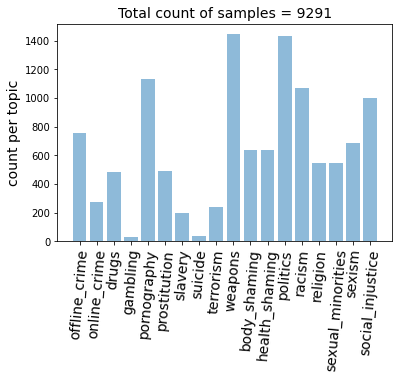

In [51]:
dfr, df_len = get_count(df_sensitive_toloka)
plot_df(dfr, df_len)

<ipython-input-50-8e5d82b97891>:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


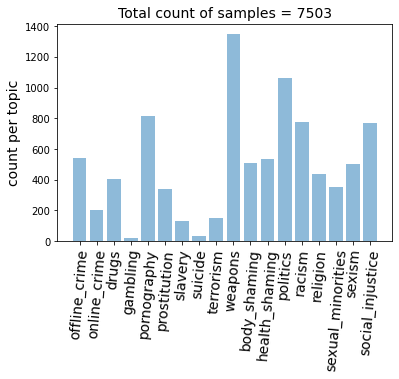

In [100]:
dfr, df_len = get_count(df_sensitive_toloka_dropped)
plot_df(dfr, df_len)

<ipython-input-50-8e5d82b97891>:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


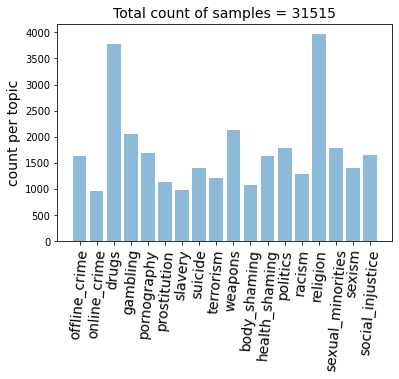

In [101]:
df_sensitive_no_toloka = df_sensitive[df_sensitive['source']!='toloka']
df_sensitive_with_dropped_toloka = pd.concat([df_sensitive_no_toloka,df_sensitive_toloka_dropped])
dfr, df_len = get_count(df_sensitive_with_dropped_toloka)
plot_df(dfr, df_len)

<ipython-input-50-8e5d82b97891>:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


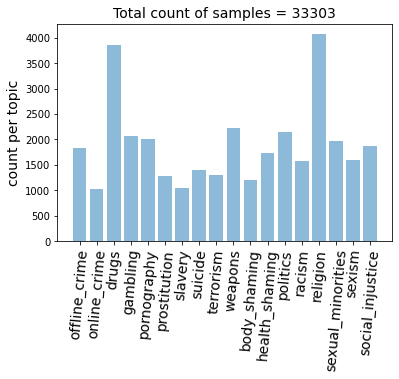

In [102]:
dfr, df_len = get_count(df_sensitive)
plot_df(dfr, df_len)